# ACT-UNet: Adaptive Computation Time for U-Net Segmentation

This notebook demonstrates the ACT-enhanced U-Net with reinforcement learning-based adaptive bottleneck depth.

## Overview
- **Model**: U-Net with ACT bottleneck that learns when to stop iterative refinement
- **Dataset**: Oxford-IIIT Pets (binary segmentation)
- **Training**: Actor-Critic RL approach for learning halting policy


> **FlashAttention check**
>
> The ACT bottleneck calls `torch.nn.functional.scaled_dot_product_attention`. On CUDA with PyTorch ≥ 2.0 this dispatches to FlashAttention automatically when the Flash kernel is enabled. Run the cell below to prefer the Flash kernel and inspect which SDP kernels are active.


In [1]:
# Optional: inspect/enable FlashAttention kernels
import torch

if torch.cuda.is_available():
    # Prefer Flash SDPA when available
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_math_sdp(False)
    torch.backends.cuda.enable_mem_efficient_sdp(False)
    print("Flash SDPA enabled; fallback kernels disabled.")
else:
    print("CUDA not available; scaled_dot_product_attention will use math fallback.")


Flash SDPA enabled; fallback kernels disabled.


In [1]:
# Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('datasets', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)


Using device: cuda


## Supported Datasets

The training pipeline currently supports two paths:

- **Oxford-IIIT Pets** – bundled helper in `toynn.act.data.PetsDataset.get_data_loaders(...)` (used below).
- **Custom segmentation folders** – point `DataConfig` at an image directory and a matching mask directory for any dataset that follows an image/mask pair structure (e.g., Cityscapes, COCO-stuff, medical volumes exported to PNG).

You can extend this list by writing another dataset wrapper inside `toynn/act/data/` and wiring it through `build_dataloaders`.


## Data Download
Download and prepare the Oxford-IIIT Pets dataset for segmentation


In [2]:
# data download
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as transforms

print("Downloading Oxford-IIIT Pets dataset...")
print("This will download ~800MB of data on first run\n")

# Download dataset with segmentation masks
dataset = OxfordIIITPet(
    root='./datasets',
    split='trainval', 
    target_types='segmentation',
    download=True,
    transform=transforms.ToTensor()
)

# Also download test split
test_dataset = OxfordIIITPet(
    root='./datasets',
    split='test',
    target_types='segmentation', 
    download=True,
    transform=transforms.ToTensor()
)

print(f"✓ Training samples: {len(dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")
print("\nDataset downloaded successfully!")


This will download ~800MB of data on first run

✓ Training samples: 3680
✓ Test samples: 3669

Dataset downloaded successfully!


## Load Dataset and Create DataLoaders


In [3]:
# Create data loaders
from training import DataConfig, build_dataloaders

# Configuration
batch_size = 8
image_size = (256, 256)
num_workers = 2

data_config = DataConfig(
    dataset="pets",
    batch_size=batch_size,
    num_workers=num_workers,
    input_size=image_size,
    root="./datasets",
    download=False,
)

train_loader, test_loader = build_dataloaders(data_config)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Image size: {image_size}")


Train batches: 460
Test batches: 459
Batch size: 8
Image size: (256, 256)


## Visualize Sample Data


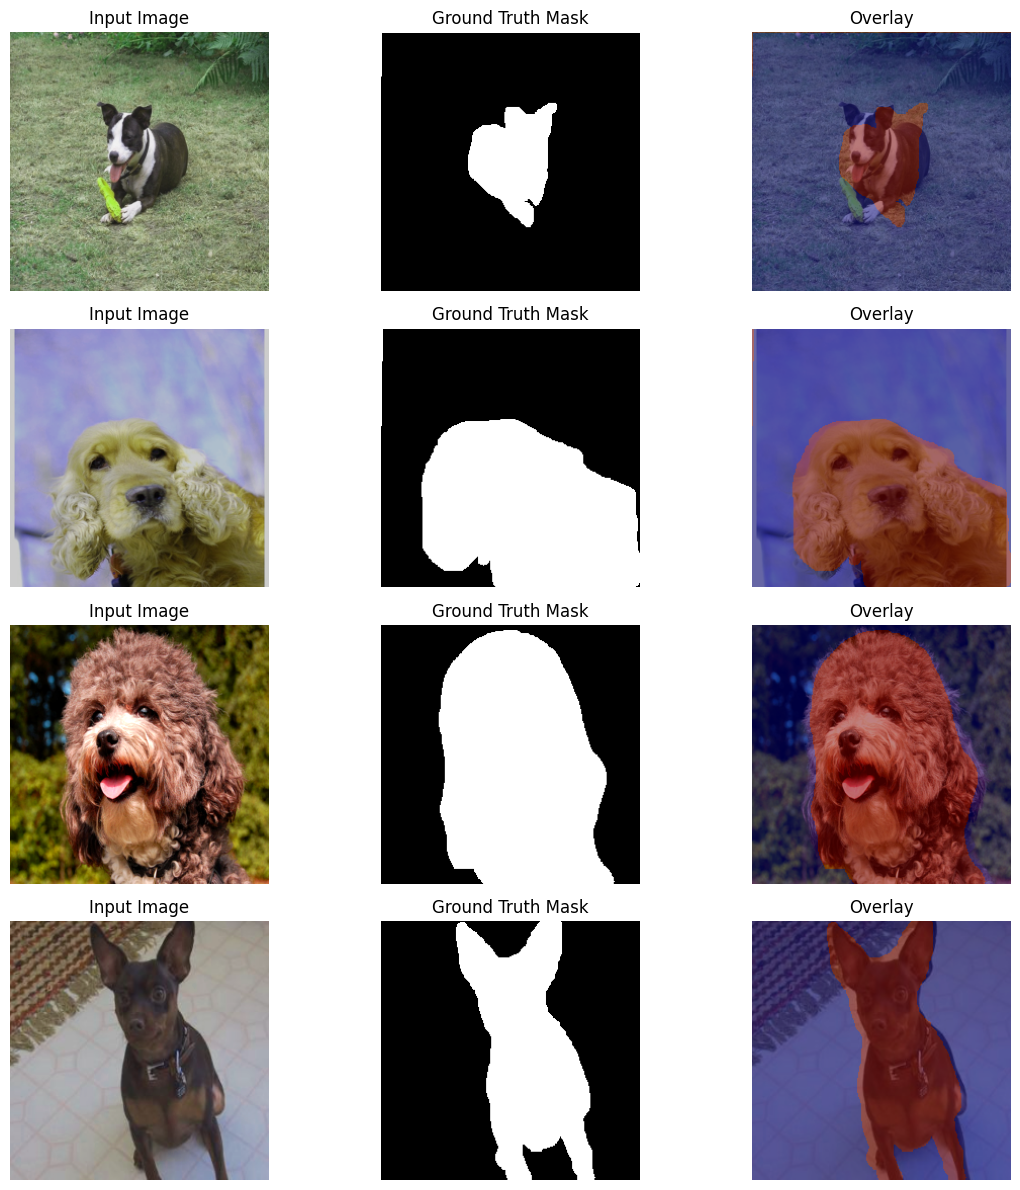

In [4]:
# Visualize samples
import matplotlib.pyplot as plt

def show_samples(loader, num_samples=4):
    batch = next(iter(loader))
    images = batch['image'][:num_samples]
    masks = batch['mask'][:num_samples]
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(images[i].permute(1, 2, 0))
        axes[i, 2].imshow(masks[i, 0], alpha=0.5, cmap='jet')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_loader)


## Create Models
We'll create both standard U-Net and ACT-enhanced U-Net for comparison


In [5]:
# Create models
from model.unet_base import UNet
from model.act_unet import ACTUNet

# Standard U-Net (baseline)
unet_baseline = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)

# ACT-enhanced U-Net
act_unet = ACTUNet(
    n_channels=3, 
    n_classes=1,
    max_iterations=5,  # Maximum K iterations in bottleneck
    bilinear=True
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Standard U-Net parameters: {count_parameters(unet_baseline):,}")
print(f"ACT-UNet parameters: {count_parameters(act_unet):,}")
print(f"Max iterations (K): {act_unet.max_iterations}")


Standard U-Net parameters: 26,710,721
ACT-UNet parameters: 26,195,652
Max iterations (K): 5


## Training ACT-UNet
Train the model with RL-based actor-critic updates


In [6]:
# Initialize trainer
from training.train import ACTTrainer

trainer = ACTTrainer(
    model=act_unet,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device,
    checkpoint_dir='./checkpoints'
)

print("Trainer initialized!")
print(f"Starting from epoch: {trainer.epoch}")
print(f"Actor-Critic alternating frequency: {trainer.alternating_freq} steps")


Trainer initialized!
Starting from epoch: 0
Actor-Critic alternating frequency: 100 steps


In [7]:
# Train model (set small number for demo, increase for full training)
num_epochs = 2  # Increase to 50-100 for full training

train_metrics, val_metrics = trainer.train(
    num_epochs=num_epochs,
    save_freq=5,
    val_freq=1
)



Epoch 0/2


Epoch 0:   1%|          | 4/460 [00:05<05:57,  1.27it/s, seg_loss=0.6136, k*=0.0, k_policy=1.0, agree=0.00%]

Epoch 0:   2%|▏         | 7/460 [00:05<02:25,  3.12it/s, seg_loss=0.6225, k*=0.0, k_policy=1.0, agree=0.00%]

Epoch 0:   2%|▏         | 9/460 [00:05<01:39,  4.52it/s, seg_loss=0.6225, k*=0.0, k_policy=1.0, agree=0.00%]

Epoch 0:   2%|▏         | 11/460 [00:06<01:21,  5.51it/s, seg_loss=0.6249, k*=0.0, k_policy=1.0, agree=0.00%]

Epoch 0:  13%|█▎        | 59/460 [00:13<01:02,  6.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  13%|█▎        | 61/460 [00:13<00:51,  7.70it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  14%|█▎        | 63/460 [00:14<00:46,  8.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  14%|█▍        | 66/460 [00:14<00:43,  9.10it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  15%|█▍        | 68/460 [00:14<00:42,  9.31it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  15%|█▌        | 71/460 [00:14<00:41,  9.36it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  16%|█▌        | 73/460 [00:15<00:41,  9.43it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  16%|█▋        | 75/460 [00:15<00:40,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  17%|█▋        | 77/460 [00:15<00:40,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  17%|█▋        | 79/460 [00:15<00:40,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  18%|█▊        | 81/460 [00:15<00:40,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  18%|█▊        | 84/460 [00:16<00:39,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  19%|█▉        | 87/460 [00:16<00:39,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  19%|█▉        | 89/460 [00:16<00:39,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  20%|█▉        | 91/460 [00:16<00:38,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  20%|██        | 93/460 [00:17<00:38,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  21%|██        | 95/460 [00:17<00:38,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  21%|██        | 97/460 [00:17<00:38,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  22%|██▏       | 100/460 [00:17<00:37,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  22%|██▏       | 102/460 [00:18<00:37,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  23%|██▎       | 105/460 [00:18<00:37,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  23%|██▎       | 107/460 [00:18<00:37,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  24%|██▍       | 110/460 [00:18<00:36,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  24%|██▍       | 112/460 [00:19<00:36,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  25%|██▍       | 114/460 [00:19<00:36,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  25%|██▌       | 116/460 [00:19<00:36,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  26%|██▌       | 118/460 [00:19<00:36,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  26%|██▌       | 120/460 [00:20<00:35,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  27%|██▋       | 122/460 [00:20<00:35,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  27%|██▋       | 124/460 [00:20<00:35,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  27%|██▋       | 126/460 [00:20<00:35,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  28%|██▊       | 128/460 [00:20<00:34,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  28%|██▊       | 130/460 [00:21<00:34,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  29%|██▉       | 133/460 [00:21<00:34,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  29%|██▉       | 135/460 [00:21<00:34,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  30%|██▉       | 137/460 [00:21<00:33,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  30%|███       | 140/460 [00:22<00:33,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  31%|███       | 142/460 [00:22<00:33,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  31%|███▏      | 144/460 [00:22<00:33,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  32%|███▏      | 147/460 [00:22<00:32,  9.56it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  33%|███▎      | 150/460 [00:23<00:32,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  33%|███▎      | 152/460 [00:23<00:32,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  33%|███▎      | 154/460 [00:23<00:32,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  34%|███▍      | 157/460 [00:23<00:32,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  35%|███▍      | 159/460 [00:24<00:31,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  35%|███▌      | 162/460 [00:24<00:31,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  36%|███▌      | 164/460 [00:24<00:31,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  36%|███▌      | 166/460 [00:24<00:30,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  37%|███▋      | 168/460 [00:25<00:30,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  37%|███▋      | 170/460 [00:25<00:30,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  38%|███▊      | 174/460 [00:25<00:30,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  38%|███▊      | 176/460 [00:25<00:30,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  39%|███▊      | 178/460 [00:26<00:29,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  39%|███▉      | 180/460 [00:26<00:29,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  40%|███▉      | 183/460 [00:26<00:29,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  40%|████      | 185/460 [00:26<00:29,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  41%|████      | 188/460 [00:27<00:28,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  41%|████▏     | 190/460 [00:27<00:28,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  42%|████▏     | 192/460 [00:27<00:28,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  42%|████▏     | 194/460 [00:27<00:28,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  43%|████▎     | 196/460 [00:28<00:27,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  43%|████▎     | 199/460 [00:28<00:27,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  44%|████▍     | 202/460 [00:28<00:27,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  44%|████▍     | 204/460 [00:28<00:27,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  45%|████▍     | 206/460 [00:29<00:26,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  45%|████▌     | 208/460 [00:29<00:26,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  46%|████▌     | 210/460 [00:29<00:26,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  46%|████▌     | 212/460 [00:29<00:26,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  47%|████▋     | 214/460 [00:29<00:25,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  47%|████▋     | 217/460 [00:30<00:25,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  48%|████▊     | 219/460 [00:30<00:25,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  48%|████▊     | 221/460 [00:30<00:25,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  48%|████▊     | 223/460 [00:30<00:24,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  49%|████▉     | 225/460 [00:31<00:24,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  49%|████▉     | 227/460 [00:31<00:24,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  50%|████▉     | 229/460 [00:31<00:24,  9.39it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  50%|█████     | 231/460 [00:31<00:24,  9.40it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  51%|█████     | 234/460 [00:32<00:23,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  51%|█████▏    | 236/460 [00:32<00:23,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  52%|█████▏    | 238/460 [00:32<00:23,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  52%|█████▏    | 240/460 [00:32<00:23,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  53%|█████▎    | 242/460 [00:32<00:22,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  53%|█████▎    | 245/460 [00:33<00:22,  9.58it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  54%|█████▍    | 248/460 [00:33<00:22,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  54%|█████▍    | 250/460 [00:33<00:22,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  55%|█████▍    | 252/460 [00:33<00:21,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  55%|█████▌    | 254/460 [00:34<00:21,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  56%|█████▌    | 256/460 [00:34<00:21,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  56%|█████▌    | 258/460 [00:34<00:21,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  57%|█████▋    | 260/460 [00:34<00:20,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  57%|█████▋    | 263/460 [00:35<00:20,  9.57it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  58%|█████▊    | 265/460 [00:35<00:20,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  58%|█████▊    | 267/460 [00:35<00:20,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  58%|█████▊    | 269/460 [00:35<00:20,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  59%|█████▉    | 271/460 [00:35<00:19,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  60%|█████▉    | 274/460 [00:36<00:19,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  60%|██████    | 276/460 [00:36<00:19,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  60%|██████    | 278/460 [00:36<00:19,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  61%|██████    | 281/460 [00:36<00:18,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  62%|██████▏   | 283/460 [00:37<00:18,  9.57it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  62%|██████▏   | 285/460 [00:37<00:18,  9.58it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  62%|██████▏   | 287/460 [00:37<00:18,  9.57it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  63%|██████▎   | 289/460 [00:37<00:17,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  63%|██████▎   | 291/460 [00:38<00:17,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  64%|██████▎   | 293/460 [00:38<00:17,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  64%|██████▍   | 295/460 [00:38<00:17,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  65%|██████▍   | 297/460 [00:38<00:17,  9.42it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  65%|██████▌   | 299/460 [00:38<00:17,  9.43it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  65%|██████▌   | 301/460 [00:39<00:16,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  66%|██████▌   | 303/460 [00:39<00:16,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  66%|██████▋   | 305/460 [00:39<00:16,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  67%|██████▋   | 308/460 [00:39<00:15,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  68%|██████▊   | 311/460 [00:40<00:15,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  68%|██████▊   | 313/460 [00:40<00:15,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  68%|██████▊   | 315/460 [00:40<00:15,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  69%|██████▉   | 318/460 [00:40<00:14,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  70%|██████▉   | 320/460 [00:41<00:14,  9.54it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  70%|███████   | 322/460 [00:41<00:14,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  71%|███████   | 325/460 [00:41<00:14,  9.60it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  71%|███████▏  | 328/460 [00:41<00:13,  9.55it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  72%|███████▏  | 330/460 [00:42<00:13,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  72%|███████▏  | 332/460 [00:42<00:13,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  73%|███████▎  | 334/460 [00:42<00:13,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  73%|███████▎  | 336/460 [00:42<00:13,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  73%|███████▎  | 338/460 [00:42<00:12,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  74%|███████▍  | 340/460 [00:43<00:12,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  75%|███████▍  | 343/460 [00:43<00:12,  9.56it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  75%|███████▌  | 345/460 [00:43<00:12,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  76%|███████▌  | 348/460 [00:44<00:11,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  76%|███████▌  | 350/460 [00:44<00:11,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  77%|███████▋  | 352/460 [00:44<00:11,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  77%|███████▋  | 355/460 [00:44<00:11,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  78%|███████▊  | 357/460 [00:44<00:10,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  78%|███████▊  | 360/460 [00:45<00:10,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  79%|███████▉  | 363/460 [00:45<00:10,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  79%|███████▉  | 365/460 [00:45<00:09,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  80%|████████  | 368/460 [00:46<00:09,  9.40it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  80%|████████  | 370/460 [00:46<00:09,  9.30it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  81%|████████  | 373/460 [00:46<00:09,  9.41it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  82%|████████▏ | 376/460 [00:46<00:08,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  82%|████████▏ | 378/460 [00:47<00:08,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  83%|████████▎ | 380/460 [00:47<00:08,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  83%|████████▎ | 382/460 [00:47<00:08,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  83%|████████▎ | 384/460 [00:47<00:08,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  84%|████████▍ | 386/460 [00:48<00:07,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  84%|████████▍ | 388/460 [00:48<00:07,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  85%|████████▍ | 390/460 [00:48<00:07,  9.34it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  85%|████████▌ | 393/460 [00:48<00:07,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  86%|████████▌ | 395/460 [00:48<00:06,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  86%|████████▋ | 397/460 [00:49<00:06,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  87%|████████▋ | 399/460 [00:49<00:06,  9.38it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  87%|████████▋ | 402/460 [00:49<00:06,  9.31it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  88%|████████▊ | 404/460 [00:49<00:06,  9.30it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  88%|████████▊ | 406/460 [00:50<00:05,  9.34it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  89%|████████▊ | 408/460 [00:50<00:05,  9.29it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  89%|████████▉ | 410/460 [00:50<00:05,  9.33it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  90%|████████▉ | 412/460 [00:50<00:05,  9.44it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  90%|█████████ | 414/460 [00:51<00:04,  9.43it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  90%|█████████ | 416/460 [00:51<00:04,  9.46it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  91%|█████████ | 418/460 [00:51<00:04,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  91%|█████████▏| 420/460 [00:51<00:04,  9.42it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  92%|█████████▏| 423/460 [00:51<00:03,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  92%|█████████▏| 425/460 [00:52<00:03,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  93%|█████████▎| 427/460 [00:52<00:03,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  93%|█████████▎| 429/460 [00:52<00:03,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  94%|█████████▎| 431/460 [00:52<00:03,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  94%|█████████▍| 433/460 [00:53<00:02,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  95%|█████████▍| 435/460 [00:53<00:02,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  95%|█████████▌| 437/460 [00:53<00:02,  9.48it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  95%|█████████▌| 439/460 [00:53<00:02,  9.45it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  96%|█████████▌| 441/460 [00:53<00:02,  9.50it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  96%|█████████▋| 443/460 [00:54<00:01,  9.49it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  97%|█████████▋| 446/460 [00:54<00:01,  9.51it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  97%|█████████▋| 448/460 [00:54<00:01,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  98%|█████████▊| 450/460 [00:54<00:01,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  98%|█████████▊| 452/460 [00:55<00:00,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  99%|█████████▉| 455/460 [00:55<00:00,  9.53it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0:  99%|█████████▉| 457/460 [00:55<00:00,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0: 100%|█████████▉| 459/460 [00:55<00:00,  9.52it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0: 100%|██████████| 460/460 [00:55<00:00,  9.47it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]

Epoch 0: 100%|██████████| 460/460 [00:56<00:00,  8.15it/s, seg_loss=0.4965, k*=0.0, k_policy=1.1, agree=0.00%]



Train Metrics:
  seg_loss: 0.5777
  act_loss: 33.7755
  optimal_k: 0.0000
  policy_k: 2.0564
  agreement: 0.0000
  td_error: 33.7755


Validation: 100%|██████████| 459/459 [00:39<00:00, 11.61it/s]


Saved best model with val_loss: 0.4932

Validation Metrics:
  seg_loss: 0.4932
  iou: 0.5036
  dice: 0.6601
  avg_iterations: 1.4098
  computation_saved: 0.7180

Epoch 1/3


Epoch 1:   0%|          | 2/460 [00:04<14:32,  1.91s/it]

Epoch 1:   1%|          | 4/460 [00:04<05:18,  1.43it/s]

Epoch 1:   1%|▏         | 6/460 [00:04<02:41,  2.81it/s]

Epoch 1:   2%|▏         | 8/460 [00:05<01:39,  4.54it/s]

Epoch 1:   2%|▏         | 10/460 [00:05<01:12,  6.23it/s]

Epoch 1:   3%|▎         | 12/460 [00:05<00:59,  7.48it/s]

Epoch 1:   3%|▎         | 15/460 [00:05<00:51,  8.62it/s]

Epoch 1:   4%|▎         | 17/460 [00:06<00:49,  8.99it/s]

Epoch 1:   4%|▍         | 19/460 [00:06<00:47,  9.22it/s]

Epoch 1:   5%|▍         | 21/460 [00:06<00:47,  9.30it/s]

Epoch 1:   5%|▌         | 23/460 [00:06<00:46,  9.32it/s]

Epoch 1:   6%|▌         | 26/460 [00:07<00:46,  9.35it/s]

Epoch 1:   6%|▌         | 28/460 [00:07<00:45,  9.42it/s]

Epoch 1:   7%|▋         | 30/460 [00:07<00:45,  9.45it/s]

Epoch 1:   7%|▋         | 32/460 [00:07<00:45,  9.44it/s]

Epoch 1:   7%|▋         | 34/460 [00:07<00:45,  9.36it/s]

Epoch 1:   8%|▊         | 36/460 [00:08<00:45,  9.34it/s]

Epoch 1:   8%|▊         | 38/460 [00:08<00:45,  9.28it/s]

Epoch 1:   9%|▊         | 40/460 [00:08<00:45,  9.31it/s]

Epoch 1:   9%|▉         | 43/460 [00:08<00:44,  9.41it/s]

Epoch 1:  10%|▉         | 45/460 [00:09<00:44,  9.40it/s]

Epoch 1:  10%|█         | 48/460 [00:09<00:43,  9.38it/s]

Epoch 1:  11%|█         | 50/460 [00:09<00:43,  9.40it/s]

Epoch 1:  12%|█▏        | 53/460 [00:10<00:43,  9.41it/s]

Epoch 1:  12%|█▏        | 55/460 [00:10<00:42,  9.46it/s]

Epoch 1:  13%|█▎        | 58/460 [00:10<00:42,  9.45it/s]

Epoch 1:  13%|█▎        | 60/460 [00:10<00:42,  9.38it/s]

Epoch 1:  13%|█▎        | 62/460 [00:10<00:42,  9.38it/s]

Epoch 1:  14%|█▍        | 64/460 [00:11<00:42,  9.35it/s]

Epoch 1:  14%|█▍        | 66/460 [00:11<00:41,  9.39it/s]

Epoch 1:  15%|█▌        | 69/460 [00:11<00:41,  9.35it/s]

Epoch 1:  15%|█▌        | 71/460 [00:11<00:41,  9.41it/s]

Epoch 1:  16%|█▌        | 74/460 [00:12<00:41,  9.34it/s]

Epoch 1:  17%|█▋        | 76/460 [00:12<00:41,  9.29it/s]

Epoch 1:  17%|█▋        | 78/460 [00:12<00:40,  9.38it/s]

Epoch 1:  17%|█▋        | 80/460 [00:12<00:40,  9.36it/s]

Epoch 1:  18%|█▊        | 82/460 [00:13<00:40,  9.38it/s]

Epoch 1:  18%|█▊        | 84/460 [00:13<00:39,  9.42it/s]

Epoch 1:  19%|█▊        | 86/460 [00:13<00:39,  9.47it/s]

Epoch 1:  20%|█▉        | 90/460 [00:13<00:39,  9.45it/s]

Epoch 1:  20%|██        | 93/460 [00:14<00:38,  9.48it/s]

Epoch 1:  21%|██        | 95/460 [00:14<00:38,  9.40it/s]

Epoch 1:  21%|██        | 97/460 [00:14<00:38,  9.45it/s]

Epoch 1:  22%|██▏       | 99/460 [00:14<00:38,  9.43it/s]

Epoch 1:  22%|██▏       | 101/460 [00:15<00:37,  9.45it/s]

Epoch 1:  22%|██▏       | 103/460 [00:15<00:37,  9.47it/s]

Epoch 1:  23%|██▎       | 105/460 [00:15<00:37,  9.40it/s]

Epoch 1:  23%|██▎       | 107/460 [00:15<00:37,  9.37it/s]

Epoch 1:  24%|██▎       | 109/460 [00:15<00:37,  9.32it/s]

Epoch 1:  24%|██▍       | 112/460 [00:16<00:36,  9.43it/s]

Epoch 1:  25%|██▌       | 115/460 [00:16<00:36,  9.42it/s]

Epoch 1:  25%|██▌       | 117/460 [00:16<00:36,  9.40it/s]

Epoch 1:  26%|██▌       | 120/460 [00:17<00:36,  9.44it/s]

Epoch 1:  27%|██▋       | 122/460 [00:17<00:35,  9.45it/s]

Epoch 1:  27%|██▋       | 124/460 [00:17<00:35,  9.48it/s]

Epoch 1:  27%|██▋       | 126/460 [00:17<00:35,  9.51it/s]

Epoch 1:  28%|██▊       | 128/460 [00:17<00:35,  9.48it/s]

Epoch 1:  28%|██▊       | 130/460 [00:18<00:35,  9.41it/s]

Epoch 1:  29%|██▊       | 132/460 [00:18<00:34,  9.49it/s]

Epoch 1:  29%|██▉       | 134/460 [00:18<00:34,  9.46it/s]

Epoch 1:  30%|██▉       | 136/460 [00:18<00:33,  9.55it/s]

Epoch 1:  30%|███       | 138/460 [00:19<00:33,  9.50it/s]

Epoch 1:  30%|███       | 140/460 [00:19<00:33,  9.49it/s]

Epoch 1:  31%|███       | 143/460 [00:19<00:33,  9.53it/s]

Epoch 1:  32%|███▏      | 145/460 [00:19<00:33,  9.51it/s]

Epoch 1:  32%|███▏      | 147/460 [00:19<00:33,  9.48it/s]

Epoch 1:  33%|███▎      | 150/460 [00:20<00:32,  9.52it/s]

Epoch 1:  33%|███▎      | 152/460 [00:20<00:32,  9.49it/s]

Epoch 1:  33%|███▎      | 154/460 [00:20<00:32,  9.45it/s]

Epoch 1:  34%|███▍      | 157/460 [00:21<00:31,  9.48it/s]

Epoch 1:  35%|███▍      | 159/460 [00:21<00:31,  9.49it/s]

Epoch 1:  35%|███▌      | 161/460 [00:21<00:31,  9.51it/s]

Epoch 1:  35%|███▌      | 163/460 [00:21<00:31,  9.54it/s]

Epoch 1:  36%|███▌      | 166/460 [00:21<00:30,  9.52it/s]

Epoch 1:  37%|███▋      | 168/460 [00:22<00:30,  9.47it/s]

Epoch 1:  37%|███▋      | 170/460 [00:22<00:30,  9.50it/s]

Epoch 1:  37%|███▋      | 172/460 [00:22<00:30,  9.49it/s]

Epoch 1:  38%|███▊      | 174/460 [00:22<00:30,  9.46it/s]

Epoch 1:  38%|███▊      | 177/460 [00:23<00:29,  9.43it/s]

Epoch 1:  39%|███▉      | 179/460 [00:23<00:29,  9.47it/s]

Epoch 1:  39%|███▉      | 181/460 [00:23<00:29,  9.44it/s]

Epoch 1:  40%|███▉      | 183/460 [00:23<00:29,  9.45it/s]

Epoch 1:  40%|████      | 185/460 [00:23<00:29,  9.48it/s]

Epoch 1:  41%|████      | 188/460 [00:24<00:28,  9.40it/s]

Epoch 1:  41%|████▏     | 190/460 [00:24<00:28,  9.47it/s]

Epoch 1:  42%|████▏     | 192/460 [00:24<00:28,  9.44it/s]

Epoch 1:  42%|████▏     | 194/460 [00:24<00:28,  9.47it/s]

Epoch 1:  43%|████▎     | 196/460 [00:25<00:27,  9.51it/s]

Epoch 1:  43%|████▎     | 198/460 [00:25<00:27,  9.52it/s]

Epoch 1:  43%|████▎     | 200/460 [00:25<00:27,  9.51it/s]

Epoch 1:  44%|████▍     | 202/460 [00:25<00:27,  9.49it/s]

Epoch 1:  45%|████▍     | 205/460 [00:26<00:27,  9.44it/s]

Epoch 1:  45%|████▌     | 207/460 [00:26<00:26,  9.47it/s]

Epoch 1:  45%|████▌     | 209/460 [00:26<00:26,  9.55it/s]

Epoch 1:  46%|████▌     | 212/460 [00:26<00:26,  9.52it/s]

Epoch 1:  47%|████▋     | 214/460 [00:27<00:25,  9.49it/s]

Epoch 1:  47%|████▋     | 216/460 [00:27<00:25,  9.46it/s]

Epoch 1:  47%|████▋     | 218/460 [00:27<00:25,  9.46it/s]

Epoch 1:  48%|████▊     | 220/460 [00:27<00:25,  9.43it/s]

Epoch 1:  48%|████▊     | 222/460 [00:27<00:25,  9.45it/s]

Epoch 1:  49%|████▉     | 225/460 [00:28<00:24,  9.45it/s]

Epoch 1:  49%|████▉     | 227/460 [00:28<00:24,  9.47it/s]

Epoch 1:  50%|████▉     | 229/460 [00:28<00:24,  9.48it/s]

Epoch 1:  50%|█████     | 231/460 [00:28<00:24,  9.50it/s]

Epoch 1:  51%|█████     | 233/460 [00:29<00:23,  9.48it/s]

Epoch 1:  51%|█████     | 235/460 [00:29<00:23,  9.48it/s]

Epoch 1:  52%|█████▏    | 237/460 [00:29<00:23,  9.45it/s]

Epoch 1:  52%|█████▏    | 239/460 [00:29<00:23,  9.45it/s]

Epoch 1:  53%|█████▎    | 242/460 [00:30<00:23,  9.42it/s]

Epoch 1:  53%|█████▎    | 244/460 [00:30<00:22,  9.45it/s]

Epoch 1:  54%|█████▎    | 247/460 [00:30<00:22,  9.49it/s]

Epoch 1:  54%|█████▍    | 249/460 [00:30<00:22,  9.46it/s]

Epoch 1:  55%|█████▍    | 251/460 [00:30<00:22,  9.46it/s]

Epoch 1:  55%|█████▌    | 253/460 [00:31<00:21,  9.44it/s]

Epoch 1:  55%|█████▌    | 255/460 [00:31<00:21,  9.43it/s]

Epoch 1:  56%|█████▌    | 257/460 [00:31<00:21,  9.43it/s]

Epoch 1:  56%|█████▋    | 259/460 [00:31<00:21,  9.48it/s]

Epoch 1:  57%|█████▋    | 261/460 [00:32<00:20,  9.48it/s]

Epoch 1:  57%|█████▋    | 263/460 [00:32<00:20,  9.47it/s]

Epoch 1:  58%|█████▊    | 265/460 [00:32<00:20,  9.42it/s]

Epoch 1:  58%|█████▊    | 267/460 [00:32<00:20,  9.25it/s]

Epoch 1:  58%|█████▊    | 269/460 [00:32<00:20,  9.32it/s]

Epoch 1:  59%|█████▉    | 271/460 [00:33<00:20,  9.42it/s]

Epoch 1:  59%|█████▉    | 273/460 [00:33<00:19,  9.46it/s]

Epoch 1:  60%|█████▉    | 275/460 [00:33<00:19,  9.40it/s]

Epoch 1:  60%|██████    | 277/460 [00:33<00:19,  9.45it/s]

Epoch 1:  61%|██████    | 279/460 [00:33<00:19,  9.41it/s]

Epoch 1:  61%|██████    | 281/460 [00:34<00:18,  9.49it/s]

Epoch 1:  62%|██████▏   | 283/460 [00:34<00:18,  9.49it/s]

Epoch 1:  62%|██████▏   | 285/460 [00:34<00:18,  9.50it/s]

Epoch 1:  62%|██████▏   | 287/460 [00:34<00:18,  9.55it/s]

Epoch 1:  63%|██████▎   | 289/460 [00:34<00:18,  9.46it/s]

Epoch 1:  63%|██████▎   | 291/460 [00:35<00:17,  9.42it/s]

Epoch 1:  64%|██████▎   | 293/460 [00:35<00:17,  9.37it/s]

Epoch 1:  64%|██████▍   | 296/460 [00:35<00:17,  9.43it/s]

Epoch 1:  65%|██████▍   | 298/460 [00:35<00:17,  9.39it/s]

Epoch 1:  65%|██████▌   | 301/460 [00:36<00:16,  9.40it/s]

Epoch 1:  66%|██████▌   | 303/460 [00:36<00:16,  9.36it/s]

Epoch 1:  66%|██████▋   | 305/460 [00:36<00:16,  9.43it/s]

Epoch 1:  67%|██████▋   | 307/460 [00:36<00:16,  9.41it/s]

Epoch 1:  67%|██████▋   | 309/460 [00:37<00:16,  9.41it/s]

Epoch 1:  68%|██████▊   | 312/460 [00:37<00:15,  9.46it/s]

Epoch 1:  68%|██████▊   | 315/460 [00:37<00:15,  9.51it/s]

Epoch 1:  69%|██████▉   | 317/460 [00:37<00:15,  9.46it/s]

Epoch 1:  69%|██████▉   | 319/460 [00:38<00:14,  9.46it/s]

Epoch 1:  70%|██████▉   | 321/460 [00:38<00:14,  9.39it/s]

Epoch 1:  70%|███████   | 323/460 [00:38<00:14,  9.40it/s]

Epoch 1:  71%|███████   | 325/460 [00:38<00:14,  9.52it/s]

Epoch 1:  71%|███████   | 327/460 [00:39<00:14,  9.47it/s]

Epoch 1:  72%|███████▏  | 329/460 [00:39<00:13,  9.47it/s]

Epoch 1:  72%|███████▏  | 331/460 [00:39<00:13,  9.44it/s]

Epoch 1:  72%|███████▏  | 333/460 [00:39<00:13,  9.43it/s]

Epoch 1:  73%|███████▎  | 335/460 [00:39<00:13,  9.47it/s]

Epoch 1:  73%|███████▎  | 337/460 [00:40<00:13,  9.41it/s]

Epoch 1:  74%|███████▎  | 339/460 [00:40<00:12,  9.48it/s]

Epoch 1:  74%|███████▍  | 342/460 [00:40<00:12,  9.46it/s]

Epoch 1:  75%|███████▍  | 344/460 [00:40<00:12,  9.49it/s]

Epoch 1:  75%|███████▌  | 346/460 [00:41<00:12,  9.50it/s]

Epoch 1:  76%|███████▌  | 348/460 [00:41<00:11,  9.45it/s]

Epoch 1:  76%|███████▋  | 351/460 [00:41<00:11,  9.43it/s]

Epoch 1:  77%|███████▋  | 354/460 [00:41<00:11,  9.47it/s]

Epoch 1:  77%|███████▋  | 356/460 [00:42<00:11,  9.45it/s]

Epoch 1:  78%|███████▊  | 358/460 [00:42<00:10,  9.51it/s]

Epoch 1:  78%|███████▊  | 360/460 [00:42<00:10,  9.46it/s]

Epoch 1:  79%|███████▉  | 363/460 [00:42<00:10,  9.47it/s]

Epoch 1:  79%|███████▉  | 365/460 [00:43<00:10,  9.40it/s]

Epoch 1:  80%|███████▉  | 367/460 [00:43<00:09,  9.44it/s]

Epoch 1:  80%|████████  | 369/460 [00:43<00:09,  9.37it/s]

Epoch 1:  81%|████████  | 371/460 [00:43<00:09,  9.41it/s]

Epoch 1:  81%|████████  | 373/460 [00:43<00:09,  9.44it/s]

Epoch 1:  82%|████████▏ | 375/460 [00:44<00:09,  9.43it/s]

Epoch 1:  82%|████████▏ | 377/460 [00:44<00:08,  9.36it/s]

Epoch 1:  82%|████████▏ | 379/460 [00:44<00:08,  9.35it/s]

Epoch 1:  83%|████████▎ | 381/460 [00:44<00:08,  9.32it/s]

Epoch 1:  83%|████████▎ | 383/460 [00:44<00:08,  9.38it/s]

Epoch 1:  84%|████████▍ | 386/460 [00:45<00:07,  9.45it/s]

Epoch 1:  84%|████████▍ | 388/460 [00:45<00:07,  9.41it/s]

Epoch 1:  85%|████████▍ | 390/460 [00:45<00:07,  9.51it/s]

Epoch 1:  85%|████████▌ | 392/460 [00:45<00:07,  9.53it/s]

Epoch 1:  86%|████████▌ | 394/460 [00:46<00:06,  9.45it/s]

Epoch 1:  86%|████████▋ | 397/460 [00:46<00:06,  9.46it/s]

Epoch 1:  87%|████████▋ | 399/460 [00:46<00:06,  9.46it/s]

Epoch 1:  87%|████████▋ | 402/460 [00:46<00:06,  9.54it/s]

Epoch 1:  88%|████████▊ | 405/460 [00:47<00:05,  9.54it/s]

Epoch 1:  88%|████████▊ | 407/460 [00:47<00:05,  9.46it/s]

Epoch 1:  89%|████████▉ | 409/460 [00:47<00:05,  9.42it/s]

Epoch 1:  89%|████████▉ | 411/460 [00:47<00:05,  9.36it/s]

Epoch 1:  90%|████████▉ | 413/460 [00:48<00:04,  9.40it/s]

Epoch 1:  90%|█████████ | 416/460 [00:48<00:04,  9.46it/s]

Epoch 1:  91%|█████████ | 419/460 [00:48<00:04,  9.45it/s]

Epoch 1:  92%|█████████▏| 421/460 [00:48<00:04,  9.42it/s]

Epoch 1:  92%|█████████▏| 424/460 [00:49<00:03,  9.46it/s]

Epoch 1:  93%|█████████▎| 426/460 [00:49<00:03,  9.41it/s]

Epoch 1:  93%|█████████▎| 428/460 [00:49<00:03,  9.43it/s]

Epoch 1:  93%|█████████▎| 430/460 [00:49<00:03,  9.40it/s]

Epoch 1:  94%|█████████▍| 432/460 [00:50<00:02,  9.39it/s]

Epoch 1:  94%|█████████▍| 434/460 [00:50<00:02,  9.48it/s]

Epoch 1:  95%|█████████▍| 436/460 [00:50<00:02,  9.44it/s]

Epoch 1:  95%|█████████▌| 438/460 [00:50<00:02,  9.47it/s]

Epoch 1:  96%|█████████▌| 440/460 [00:50<00:02,  9.45it/s]

Epoch 1:  96%|█████████▌| 442/460 [00:51<00:01,  9.47it/s]

Epoch 1:  97%|█████████▋| 444/460 [00:51<00:01,  9.50it/s]

Epoch 1:  97%|█████████▋| 446/460 [00:51<00:01,  9.44it/s]

Epoch 1:  97%|█████████▋| 448/460 [00:51<00:01,  9.48it/s]

Epoch 1:  98%|█████████▊| 451/460 [00:52<00:00,  9.49it/s]

Epoch 1:  99%|█████████▊| 454/460 [00:52<00:00,  9.49it/s]

Epoch 1:  99%|█████████▉| 456/460 [00:52<00:00,  9.47it/s]

Epoch 1: 100%|█████████▉| 458/460 [00:52<00:00,  9.51it/s]

Epoch 1: 100%|██████████| 460/460 [00:53<00:00,  9.50it/s]

Epoch 1: 100%|██████████| 460/460 [00:53<00:00,  8.57it/s]



Train Metrics:


Validation: 100%|██████████| 459/459 [00:39<00:00, 11.51it/s]


Saved best model with val_loss: 0.4905

Validation Metrics:
  seg_loss: 0.4905
  iou: 0.5033
  dice: 0.6600
  avg_iterations: 1.3243
  computation_saved: 0.7351

Training complete!


## Evaluation and Visualization


In [ ]:
# Evaluate model and visualize results
@torch.no_grad()
def evaluate_and_visualize(model, loader, num_samples=4):
    model.eval()
    batch = next(iter(loader))
    images = batch['image'][:num_samples].to(device)
    masks = batch['mask'][:num_samples].to(device)
    
    # Get predictions with ACT info
    if hasattr(model, 'bottleneck'):  # ACT-UNet
        predictions, act_info = model(images, return_act_info=True)
        halt_iters = act_info['halt_iterations'].cpu().numpy()
    else:  # Standard U-Net
        predictions = model(images)
        halt_iters = None
    
    # Convert to probabilities
    pred_probs = torch.sigmoid(predictions).cpu()
    pred_binary = (pred_probs > 0.5).float()
    
    # Denormalize images
    images_cpu = images.cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images_vis = images_cpu * std + mean
    images_vis = torch.clamp(images_vis, 0, 1)
    
    # Create visualization
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, num_samples*3))
    
    for i in range(num_samples):
        # Input image
        axes[i, 0].imshow(images_vis[i].permute(1, 2, 0))
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(masks[i, 0].cpu(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(pred_binary[i, 0], cmap='gray')
        if halt_iters is not None:
            axes[i, 2].set_title(f'Prediction (k={halt_iters[i]})')
        else:
            axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        
        # Probability map
        axes[i, 3].imshow(pred_probs[i, 0], cmap='viridis', vmin=0, vmax=1)
        axes[i, 3].set_title('Probability')
        axes[i, 3].axis('off')
        
        # Error map
        error = torch.abs(pred_binary[i, 0] - masks[i, 0].cpu())
        axes[i, 4].imshow(error, cmap='hot')
        axes[i, 4].set_title('Error')
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print ACT statistics if available
    if halt_iters is not None:
        print(f"Halt iterations: {halt_iters}")
        print(f"Average iterations: {halt_iters.mean():.2f}")
        print(f"Computation saved: {(1 - halt_iters.mean()/model.max_iterations)*100:.1f}%")

# Evaluate ACT-UNet
print("ACT-UNet Results:")
evaluate_and_visualize(act_unet, test_loader)


## Adaptive Depth Analysis


In [ ]:
# Analyze adaptive depth distribution
@torch.no_grad()
def analyze_depth_distribution(model, loader, num_batches=10):
    model.eval()
    all_iterations = []
    all_difficulties = []  # We'll use loss as a proxy for difficulty
    
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
            
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        
        # Get predictions with ACT info
        predictions, act_info = model(images, return_act_info=True)
        halt_iters = act_info['halt_iterations'].cpu().numpy()
        all_iterations.extend(halt_iters)
        
        # Compute per-sample loss as difficulty proxy
        from training.losses import SegmentationLoss
        loss_fn = SegmentationLoss()
        for j in range(images.shape[0]):
            loss = loss_fn(predictions[j:j+1], masks[j:j+1]).item()
            all_difficulties.append(loss)
    
    all_iterations = np.array(all_iterations)
    all_difficulties = np.array(all_difficulties)
    
    # Plot distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram of iterations
    axes[0].hist(all_iterations, bins=model.max_iterations, edgecolor='black')
    axes[0].set_xlabel('Number of Iterations (k)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Adaptive Depths')
    axes[0].axvline(all_iterations.mean(), color='red', linestyle='--', 
                    label=f'Mean: {all_iterations.mean():.2f}')
    axes[0].legend()
    
    # Difficulty vs Iterations
    axes[1].scatter(all_difficulties, all_iterations, alpha=0.5)
    axes[1].set_xlabel('Task Difficulty (Loss)')
    axes[1].set_ylabel('Iterations Used')
    axes[1].set_title('Adaptive Depth vs Difficulty')
    
    # Iteration counts
    unique, counts = np.unique(all_iterations, return_counts=True)
    axes[2].bar(unique, counts, edgecolor='black')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Iteration Usage')
    axes[2].set_xticks(range(model.max_iterations))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\\nAdaptive Depth Statistics:")
    print(f"Mean iterations: {all_iterations.mean():.2f}")
    print(f"Std iterations: {all_iterations.std():.2f}")
    print(f"Min iterations: {all_iterations.min()}")
    print(f"Max iterations: {all_iterations.max()}")
    print(f"Computation saved: {(1 - all_iterations.mean()/model.max_iterations)*100:.1f}%")
    
    # Correlation with difficulty
    correlation = np.corrcoef(all_difficulties, all_iterations)[0, 1]
    print(f"Correlation (difficulty vs iterations): {correlation:.3f}")

# Analyze depth distribution
if hasattr(act_unet, 'bottleneck'):
    analyze_depth_distribution(act_unet, test_loader)
